In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import collections
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.image as mpimg
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import gc

# Plot Statistics of Descriptor Evaluation 
Select an evalation .csv file and plot away.

In [2]:
#####################
### PLOT FUNCTIONS
#####################

def draw_square(
    ax,
    data:np.array,
    cmap:mpl.colors.LinearSegmentedColormap,
    spines_visibility:Tuple[bool, bool, bool, bool]=[False, False, False, False],
    tickparams:Dict={'axis':'both', 'which':'both', 'bottom':False, 'left':False},
    xticklabels:List=[],
    yticklabels:List=[],
    xlabel:str='',
    ylabel:str='',
    title:str='',
    textcolor:str='black'):
    """Draw red to green sqares for goodness of a descriptor/detector
    combination."""

    # set tick params
    ax.tick_params(**tickparams)

    ax.spines['top'].set_visible(spines_visibility[0])
    ax.spines['right'].set_visible(spines_visibility[1])
    ax.spines['bottom'].set_visible(spines_visibility[2])
    ax.spines['left'].set_visible(spines_visibility[3])

    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_title(title)

    _vals = data[~np.isnan(data)]
    ax.imshow(data, cmap=cmap, vmin=np.min(_vals), vmax=np.max(_vals))

    # Loop over data to dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):

            _data = data * 100
            t = '' if np.isnan(_data[i, j]) else '{:.1f}'.format(_data[i, j])
            text = ax.text(j, i, 
                           t, 
                           ha='center', 
                           va='center', 
                           color=textcolor);


#####################
### FUNCTIONS
#####################
def save_figure(
  path_output:str,
  fig_name:str, 
  figure: mpl.figure.Figure,
  dpi:int=300,
  tight_layout:bool=False) -> None:

    if not os.path.exists(path_output):
        os.makedirs(path_output, exist_ok=True)

    f_out = os.path.join(path_output, fig_name)
  
    if tight_layout:
        figure.savefig(f_out, bbox_inches='tight', pad_inches=0, dpi=dpi)
    else:
        figure.savefig(f_out, dpi=dpi)


#####################
### SETTINGS
#####################
id2name = {
    'sift': 'SIFT',
    'lift': 'LIFT',
    'tilde': 'TILDE',
    'superpoint': 'SuperPoint',
    'tcovdet': 'TCovDet',
    'tfeat': 'TFeat',
    'doap': 'DOAP',
    'v_set_01': 'Set 1',
    'v_set_02': 'Set 2',
    'v_set_03': 'Set 3',
    'v_set_04': 'Set 4',
    'v_set_05': 'Set 5',
    'v_set_06': 'Set 6',
    'v_set_07': 'Set 7',
    'v_set_08': 'Set 8',
    'v_set_09': 'Set 9',
    'v_set_10': 'Set 10',
    'v_set_11': 'Set 11',
    'v_set_12': 'Set 12',
    'v_set_13': 'Set 13'
}

color_scheme = {
  'sift': '#1f77b4',
  'lift': '#ff7f0e',
  'tilde': '#2ca02c',
  'superpoint': '#d62728',
  'tcovdet': '#9467bd',
  'tfeat': '#2ca02c',
  'doap': '#9467bd'
}

keypoint_threshold_colors = ['skyblue', 'purple', 'crimson']

marker_scheme = {
  'sift': 'o',
  'lift': 'x',
  'tilde': 'd',
  'superpoint': '^',
  'tcovdet': 'h',
  'tfeat': '*',
  'doap': 'p'
}

line_styles = ['-', '-.', ':', '--']

data_dir = '/home/mizzade/Workspace/diplom/outputs/eval_matching_pipeline'
output_dir_root = '/home/mizzade/Workspace/diplom/outputs/eval_matching_pipeline/plots'

eval_dict = {
    'nn2way': {
        'file_name': 'descriptor_matching_eisert_nn2way',
        'out_dir': 'nn2way'},
    'bf_ratio': {
        'file_name': 'descriptor_matching_eisert_bf_ratio',
        'out_dir': 'brute_force_ratio'},
    'bf': {
        'file_name': 'descriptor_matching_eisert_bf',
        'out_dir': 'brute_force'},
    'flann': {
        'file_name': 'descriptor_matching_eisert_flann',
        'out_dir': 'flann'},
    'flann_ratio': {
        'file_name': 'descriptor_matching_eisert_flann_ratio',
        'out_dir': 'flann_ratio'}
}

#####################
### MAIN
#####################

save_figures = False

no_normalization = False
postfix = '_no_normalization' if no_normalization else ''

# 1. Select which evaluation to plot (Make sure, data exist in data_dir):
# nn2way | bf | bf_ratio | flann | flann_ratio
eval_selection = 'nn2way'

file_name = eval_dict[eval_selection]['file_name']
file_name += postfix + '.csv'

output_dir = os.path.join(output_dir_root, eval_dict[eval_selection]['out_dir'] + postfix)

# Load data
df = pd.read_csv(os.path.join(data_dir, file_name), sep=',', comment='#')

descriptor_names = sorted(df.descriptor_name.unique())
detector_names = sorted(df.detector_name.unique())
set_names = sorted(df.set_name.unique())
desc_distance_thresholds = sorted(df.desc_distance_threshold.unique())
kpts_thresholds = sorted(df.kpts_threshold.unique())

desc_dist = desc_distance_thresholds[0]
kp_thresh = kpts_thresholds[0]


In [3]:
df.head()

,collection_name,set_name,kpts_threshold,descriptor_name,detector_name,matching_method,desc_distance_threshold,ransac_threshold,ransac_confidence,num_kpts_i,...,matchability,accuracy_matches,mse_matching,max_num_inliers,num_inliers,inlier_ratio,avg_distance,mse_estimation,lambda,accuracy_inliers
0,eisert,v_set_01,1000,doap,lift,nn2way,0.7,3,0.99,1000,...,0.145000,0.166052,7.077380,145,10,0.068966,0.343402,0.156199,1.0000,0.885533
1,eisert,v_set_01,5000,doap,lift,nn2way,0.7,3,0.99,5000,...,0.137200,0.198748,14.812769,686,11,0.016035,0.457379,0.195903,1.0000,0.847540
2,eisert,v_set_01,10000,doap,lift,nn2way,0.7,3,0.99,9973,...,0.138612,0.206588,20.582999,1348,13,0.009644,0.366326,0.139911,0.9725,0.877891
3,eisert,v_set_01,1000,doap,sift,nn2way,0.7,3,0.99,1000,...,0.158000,0.065593,8.231064,158,10,0.063291,0.210773,0.111421,1.0000,0.929742
4,eisert,v_set_01,5000,doap,sift,nn2way,0.7,3,0.99,1164,...,0.156743,0.065303,8.763792,179,10,0.055866,0.290265,0.154868,0.2284,0.903245



## Zeige die Anzahl der gefundnen Keypunkte bei jedem Bild, in jedem Set für alle Detektoren.

In [10]:
len(set_names), len(detector_names)

(13, 5)

In [27]:
# Needs: kp_thresh, set_names, detector_names
def get_num_found_kpts_for_kpthresh(
    df: pd.DataFrame,
    kp_thresh:int,
    detector_names:List[str],
    set_names:List[str]
    ) -> np.array:
    """Returns a scoremap (2*detectors x sets), containing the 
    number of found kpts for each image in each set for ALL
    detectors and a SINGLE kpthresh value.
    """

    _df = df[(df.kpts_threshold == kp_thresh)]
    _g = _df.groupby(['detector_name', 'set_name'], as_index=False)

    scoremap = np.zeros((len(2*detector_names), len(set_names)))
    idxmap = np.zeros((len(2*detector_names), len(set_names)))

    det2row = {k: v for v, k in enumerate(detector_names)}
    set2col = {k: v for v, k in enumerate(set_names)}

    for gname, group in _g:
        i = det2row[gname[0]]
        j = set2col[gname[1]]

        kpts = np.mean(group[['num_kpts_i', 'num_kpts_j']].values, axis=0)
        scoremap[2*i][j] = kpts[0]
        scoremap[2*i + 1][j] = kpts[1]
        
        # Color indices
        idxmap[2*i][j] = i
        idxmap[2*i + 1][j] = i
        
    return scoremap, idxmap

    
kp_thresh = 1000
scoremap, cidxmap = get_num_found_kpts_for_kpthresh(df, kp_thresh, detector_names, set_names)
        
        

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])

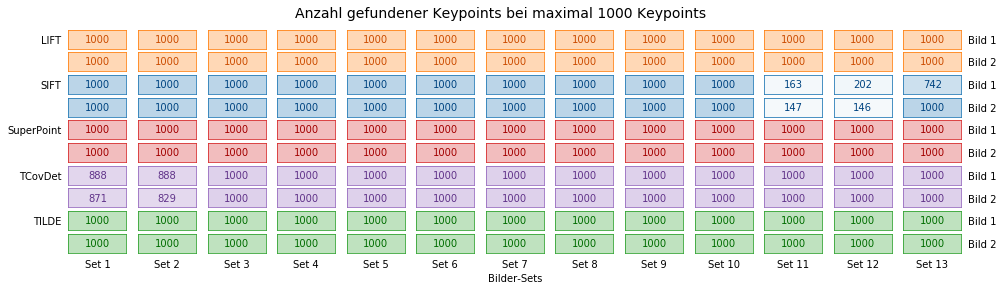

In [25]:
# Get the corresponding color for each detector as [r,g,b,a] list
_colors = [list(colors.to_rgba(color_scheme[x])) for x in detector_names]

# Set each color's alpha to 0.3
for _c in _colors:
    _c[3] = 0.3

# From that, create a color map
cmap_custom = mpl.colors.LinearSegmentedColormap.from_list("", _colors, len(detector_names))


# Build a heatmap, that has the same color (color of detector) for each two rows.
num_images_in_set = 2
_xvals = np.zeros((len(detector_names) * num_images_in_set, len(set_names)))
_yvals = np.vstack([np.arange(5), np.arange(5)]).T.reshape(-1, 1)
colormap = _xvals + _yvals


for kp_thresh in kpts_thresholds[:1]:
    
    ### Compute map of found keypoints for this kpts threshold.
    
    ### CREATE DATA
    # Get the number of keypoints for each image in each set for each detector
    _g = df.groupby(['kpts_threshold', 'detector_name', 'set_name'], as_index=False)
    
    kpts_per_detector = []
    for detector_name in detector_names:
        
        kpts_per_set = []
        for set_name in set_names:
            idx = _g.groups[(kp_thresh, detector_name, set_name)]
            kpts = df.iloc[idx][['num_kpts_i', 'num_kpts_j']].values[0]
            kpts_per_set.append(kpts)
        
        kpts_per_detector.append(kpts_per_set)
        
    kpts_per_detector = np.array(kpts_per_detector)
    
    
    plt.rcParams['figure.figsize'] = [16, 4]    
    fig, axes = plt.subplots(2 * len(detector_names), len(set_names))
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i][j]
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 1)
            
            # Build a rectangle in axes coords
            left, width = .25, .5
            bottom, height = .25, .5
            right = left + width
            top = bottom + height

            _i = np.int(0.5 * i)
            _k = np.int(i % 2)

            _z = np.int(colormap[i][j])
            detector_name = detector_names[_z]
            _fcolor = cmap_custom(_z )
            _ecolor = color_scheme[detector_name]

            ax.tick_params(
                axis='both',
                which='both',
                bottom=False,
                left=False,
                right=False)


            # Background color of plot
            _fcolor_alpha = 0.3 * kpts_per_detector[_i][j][_k] / kp_thresh
            _fcolor = list(_fcolor)
            _fcolor[3] = _fcolor_alpha
            #_fcolor[3] = _fcolor_alpha
            ax.set_facecolor(_fcolor)

            # Colors of spines
            ax.spines['bottom'].set_color(_ecolor)
            ax.spines['top'].set_color(_ecolor) 
            ax.spines['right'].set_color(_ecolor)
            ax.spines['left'].set_color(_ecolor)

            # Tick labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            # Set "Bild i" on the right side.
            if j == axes.shape[1] - 1:
                ax.yaxis.tick_right() # Y-Tick labels on right side
                ax.set_yticks([.5])
                ax.set_yticklabels(['Bild {}'.format(_k + 1)])
                ax.tick_params(right=False)

            # Set "Set i" on the bottom
            if i == axes.shape[0] - 1:
                ax.set_xticks([.5])
                ax.set_xticklabels(['Set {}'.format(j + 1)])
                ax.tick_params(bottom=False)

            # Set detectore names on the left side.
            if j == 0 and _k == 0:
                ax.set_yticks([.5])
                ax.set_yticklabels([id2name[detector_names[_z]]])
                ax.tick_params(left=False)
                #h = ax.set_ylabel(id2name[detector_names[_z]], horizontalalignment='right')
                #ax.yaxis.set_label_coords(-.1, .25)
                #h.set_rotation(0)

            # Set "Bilderset" on bottom
            if j == 6 and i == axes.shape[0] - 1:
                ax.set_xlabel('Bilder-Sets')
                #ax.tick_params(bottom=False)
                

            # Set color for text as a little darker then edge color
            _tcolor = np.array(list(colors.to_rgba(_ecolor)))
            _tcolor -= [0.2, 0.2, 0.2, 0]
            _tcolor = np.clip(_tcolor, 0, 1)

            ax.text(0.5 * (left + right), 0.5*(bottom+top), 
                    kpts_per_detector[_i][j][_k],
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=_tcolor)

    fig.suptitle('Anzahl gefundener Keypoints bei maximal {} Keypoints'.format(kp_thresh), fontsize=14)        
    fig.subplots_adjust(top=0.9)

    # Save
    if save_figures:
        save_figure(output_dir,
            'num_found_keypoints_for_each_set_at_kpthresh_{}.png'.format(kp_thresh),
            fig)


### Durchschnittliche Anzahl gefundener Keypoints in jedem Set für alle Detektoren für die jeweiligen Keypoint-Thresholds.

In [ ]:
# Contains avg number of found keypoints in a set for a detector for all keypoint thresholds

###################
### CREATE DATA
###################

kpts_per_detector = []
for detector_name in detector_names:
    ### CREATE DATA
    # Get the number of keypoints for each image in each set for each detector
    _g = df.groupby(['kpts_threshold', 'detector_name', 'set_name'], as_index=False)
    
    kpts_per_thresh = []
    for kp_thresh in kpts_thresholds:
        
        kpts_per_set = []
        for set_name in set_names:
            idx = _g.groups[(kp_thresh, detector_name, set_name)]
            avg_kpts = np.mean(df.iloc[idx][['num_kpts_i', 'num_kpts_j']].values[0])
            
            # Save in list per set
            kpts_per_set.append(avg_kpts)
        
        # Save in list per threshold
        kpts_per_thresh.append(kpts_per_set)
        
    # Save in list per detector
    kpts_per_detector.append(kpts_per_thresh)

kpts_per_detector = np.array(kpts_per_detector)

### BALKEN GRAPHEN
###################
plt.rcParams['figure.figsize'] = [16, 4]
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

ax = axes[0]
ax.tick_params(axis='x', which='both', labelrotation=0) # Rotate x-axis label
# ax.set_title("Durchschnittliche Anzahl gefundener in allen Bilder-Sets für verschieden Keypoint-Thresholds")

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# get the first M colors
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(detector_names)]

xs = [id2name[x] for x in detector_names]
x_labels = xs

N = len(x_labels)         # number of ticks
M = len(kpts_thresholds)  # number of bars per tick
D = 3                     # distance between ticks

# Tick position values
ticks = np.arange(N) * D

# Width of one bar:
width_of_bar = 0.5 * D / M

# margin after each bar:
margin_of_bar = 0.5 * width_of_bar

# Set labels for each tick
ax.set_xticklabels(x_labels)

# Width of a "block" of bars.
width_of_block = M * width_of_bar + (M-1) * margin_of_bar

# Set position of ticks
ax.set_xticks(ticks + width_of_block * 0.5 - width_of_bar * 0.5 - margin_of_bar)

# Print keypoint threshold as horizontal lines
for i, kp_thresh in enumerate(kpts_thresholds):
    ax.axhline(kp_thresh, 
        color=keypoint_threshold_colors[i], 
        alpha=0.4, 
        linestyle=line_styles[3],
        dashes=[1, 4],
        label='{} Keypoints'.format(kp_thresh))

for num_of_tick, detector_name in enumerate(detector_names):
    for num_of_bar, kp_thresh in enumerate(kpts_thresholds):
        _fcolor = list(colors.to_rgba(color_scheme[detector_name]))
        _fcolor[3] = 0.3 # set alpha to 0.3
        _ecolor = colors.to_rgba(color_scheme[detector_name])
            
        x = ticks[num_of_tick] + num_of_bar * width_of_bar + (num_of_bar -1) * margin_of_bar
        y = np.mean(kpts_per_detector[num_of_tick][num_of_bar])

        ax.bar(
            x,
            y,
            width_of_bar,
            facecolor=_fcolor,
            edgecolor=_ecolor)

ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.3))


### SECOND SUBPLOT
##################
# Create a colormap map, so the heatmap has the colors at the correct positions
# Each row is a detector with corresponding color
# Each column a keypoint threshold
# Each value of (row, col) is the average number of found keypoints over all sets.

ax = axes[1]
ax.yaxis.tick_right() # Y-Tick labels on right side
ax.set_yticklabels(['']+[id2name[x] for x in detector_names])

ax.set_xticks(np.arange(len(kpts_thresholds)))
ax.set_xticklabels(kpts_thresholds)
ax.tick_params(axis='x', which='both', labelrotation=30) # Rotate x-axis label

# Remove ticks, but not labels
ax.tick_params(
    bottom=False,
    right=False)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

colormap = np.zeros((len(detector_names), len(kpts_thresholds))) + np.arange(len(detector_names))[:, np.newaxis]
heatmap_kpts = np.zeros(kpts_per_detector.shape[:2])

for i in range(heatmap_kpts.shape[0]):
    for j in range(heatmap_kpts.shape[1]):
        heatmap_kpts[i][j] = np.mean(kpts_per_detector[i][j])


    
ax.imshow(colormap, cmap=cmap_custom)
for i in range(heatmap_kpts.shape[0]):
    for j in range(heatmap_kpts.shape[1]):
        t = '{}'.format(np.int(heatmap_kpts[i, j]))
        text = ax.text(j, i, 
                       t, 
                       ha='center', 
                       va='center', 
                       color='black');

fig.suptitle("Durchschnittliche Anzahl gefundener in allen Bilder-Sets für verschieden Keypoint-Thresholds", 
             fontsize=14,
             y=0.95)
fig.tight_layout()

# Save
if save_figures:
    save_figure(output_dir,
            'avg_num_found_keypoints_for_each_detector.png',
            fig)


### Durchschnittliche Anzahl gefundener Keypoints  für jeden Detektor über alle Sets.

In [ ]:
###################
### CREATE DATA
###################

kpts_per_detector = []
for detector_name in detector_names:
    ### CREATE DATA
    # Get the number of keypoints for each image in each set for each detector
    _g = df.groupby(['kpts_threshold', 'detector_name', 'set_name'], as_index=False)
    
    kpts_per_thresh = []
    for kp_thresh in kpts_thresholds:
        
        kpts_per_set = []
        for set_name in set_names:
            idx = _g.groups[(kp_thresh, detector_name, set_name)]
            avg_kpts = np.mean(df.iloc[idx][['num_kpts_i', 'num_kpts_j']].values[0])
            
            # Save in list per set
            kpts_per_set.append(avg_kpts)
        
        # Save in list per threshold
        kpts_per_thresh.append(kpts_per_set)
        
    # Save in list per detector
    kpts_per_detector.append(kpts_per_thresh)

kpts_per_detector = np.array(kpts_per_detector)

### BALKEN GRAPHEN
###################
for k, kp_thresh in enumerate(kpts_thresholds):
    plt.rcParams['figure.figsize'] = [16, 3]
    fig, axes = plt.subplots(1, 1)

    ax = axes
    ax.tick_params(axis='x', which='both', labelrotation=0) # Rotate x-axis label
    # ax.set_title("Durchschnittliche Anzahl gefundener in allen Bilder-Sets für verschieden Keypoint-Thresholds")

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # get the first M colors
    _colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(detector_names)]

    xs = [id2name[x] for x in set_names]
    x_labels = xs

    N = len(x_labels)         # number of ticks
    M = len(detector_names)  # number of bars per tick
    D = 3                     # distance between ticks

    # Tick position values
    ticks = np.arange(N) * D

    # Width of one bar:
    width_of_bar = 0.5 * D / M

    # margin after each bar:
    margin_of_bar = 0.5 * width_of_bar

    # Set labels for each tick
    ax.set_xticklabels(x_labels)

    # Width of a "block" of bars.
    width_of_block = M * width_of_bar + (M-1) * margin_of_bar

    # Set position of ticks
    ax.set_xticks(ticks + width_of_block * 0.5 - width_of_bar * 0.5 - margin_of_bar)

    for num_of_tick, set_name in enumerate(x_labels):
        for num_of_bar, detector_name in enumerate(detector_names):
            _fcolor = list(colors.to_rgba(color_scheme[detector_name]))
            _fcolor[3] = 0.3 # set alpha to 0.3
            _ecolor = colors.to_rgba(color_scheme[detector_name])

            x = ticks[num_of_tick] + num_of_bar * width_of_bar + (num_of_bar -1) * margin_of_bar
            y = kpts_per_detector[num_of_bar][k][num_of_bar]
            
            labeltext = None
            if num_of_tick == 0:
                labeltext = '{}'.format(detector_name)

            ax.bar(
                x,
                y,
                width_of_bar,
                facecolor=_fcolor,
                edgecolor=_ecolor,
                label=labeltext)

    ax.legend(loc='upper left', bbox_to_anchor=(0.0, -.1))
    
    fig.suptitle('Durchschnittliche Anzahl gefundener Keypoints in jedem Bilder-Set pro Detektor für maximal {} Keypoints'.format(kp_thresh))
    # Save
    if save_figures:
        save_figure(output_dir,
            'avg_num_found_keypoints_for_each_set_at_kpthresh_{}.png'.format(kp_thresh),
            fig)

### Bewertung der Deskriptor-Detektor Kombinationen für die jeweiligen Keypoint-Thresholds.

In [ ]:
def draw_square(
    ax,
    data:np.array,
    cmap:mpl.colors.LinearSegmentedColormap,
    spines_visibility:Tuple[bool, bool, bool, bool]=[False, False, False, False],
    tickparams:Dict={'axis':'both', 'which':'both', 'bottom':False, 'left':False},
    xticklabels:List[str]=[''] + [id2name[x] for x in detector_names],
    yticklabels:List[str]= [''] + [id2name[x] for x in descriptor_names],
    xlabel:str='',
    ylabel:str='',
    title:str='',
    textcolor:str='black'):
    
#     ax.tick_params(
#         axis='both',         # changes apply to the axis
#         which='both',        # both major and minor ticks are affected
#         bottom=False,        # ticks along the bottom edge are off
#         left=False)          # ticks along left edge are off
    ax.tick_params(**tickparams)

    ax.spines['top'].set_visible(spines_visibility[0])
    ax.spines['right'].set_visible(spines_visibility[1])
    ax.spines['bottom'].set_visible(spines_visibility[2])
    ax.spines['left'].set_visible(spines_visibility[3])

    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_title(title)

    _vals = data[~np.isnan(data)]
    ax.imshow(data, cmap=cmap, vmin=np.min(_vals), vmax=np.max(_vals))

    # Loop over data to dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):

            _data = data * 100
            t = '' if np.isnan(_data[i, j]) else '{:.1f}'.format(_data[i, j])
            text = ax.text(j, i, 
                           t, 
                           ha='center', 
                           va='center', 
                           color=textcolor);

In [ ]:
####################
### GENERATE DATA
####################
scoremaps = []
heatmaps_accm = [] 
heatmaps_mat = []  

heatmaps_acci = [] 
heatmaps_ir = []

for kp_thresh in kpts_thresholds:
    heatmap_accm = [] # accuracy of matches
    heatmap_mat = []  # matchability

    heatmap_acci = [] # accuracy of inliers
    heatmap_ir = []   # inlier ratio
    
    for descriptor_name in descriptor_names:

        accm_per_detector = [] # acc for matches
        mat_per_detector = []  # match ratio
        acci_per_detector = [] # acc for inliers
        ir_per_detector = []   # inlier ratio
        
        keypoints_per_detector = [] # number of keypoints  found by detector

        for detector_name in detector_names:

            _df = df[(df.kpts_threshold == kp_thresh) &
                     (df.desc_distance_threshold == desc_dist) &
                     (df.descriptor_name == descriptor_name) &
                     (df.detector_name == detector_name)]

            accm = np.mean(_df.accuracy_matches) # accuracy of matches
            mat = np.mean(_df.matchability)      # matchability ratio

            acci = np.mean(_df.accuracy_inliers) # accuracy of inliers
            ir = np.mean(_df.inlier_ratio)       # inlier ratio
            
            # Add to corresponding lists
            accm_per_detector.append(accm)
            mat_per_detector.append(mat)
            acci_per_detector.append(acci)
            ir_per_detector.append(ir)
            
        # Add to corresponding lists    
        heatmap_accm.append(accm_per_detector)
        heatmap_mat.append(mat_per_detector)
        heatmap_acci.append(acci_per_detector)
        heatmap_ir.append(ir_per_detector)

    # Convet to numpy array    
    heatmap_accm = np.array(heatmap_accm)
    heatmap_mat = np.array(heatmap_mat)
    heatmap_acci = np.array(heatmap_acci)
    heatmap_ir = np.array(heatmap_ir)
    
    scoremap = 0.25 * (heatmap_mat + heatmap_accm + heatmap_ir + heatmap_acci)

    
    # Add to global maps
    scoremaps.append(scoremap)
    heatmaps_accm.append(heatmap_accm) 
    heatmaps_mat.append(heatmap_mat)
    heatmaps_acci.append(heatmap_acci)
    heatmaps_ir.append(heatmap_ir)


In [ ]:
for _i, kp_thresh in enumerate(kpts_thresholds):
    
    ###############
    ### Drawing
    ###############
    plt.rcParams['figure.figsize'] = [15, 12]
    fig, axes = plt.subplots(2, 3)
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['tomato', 'gold', 'forestgreen'], 10)
    text_color = 'black'

    # Matchability
    ###################
    ax = axes[0][0]
    draw_square(
        ax,
        heatmaps_mat[_i],
        cmap,
        spines_visibility=[False, False, False, False],
        xticklabels=[''] + [id2name[x] for x in detector_names],
        yticklabels=[''] + [id2name[x] for x in descriptor_names],
        xlabel='Detektoren',
        ylabel='Deskriptoren',
        title='Übereinstimmungsquote in %')
    

    # Accuracy
    ###################
    ax = axes[0][1]
    draw_square(
        ax,
        heatmaps_accm[_i],
        cmap,
        spines_visibility=[False, False, False, False],
        xticklabels=[''] + [id2name[x] for x in detector_names],
        yticklabels=[],
        xlabel='Detektoren',
        ylabel='',
        title='Genauigkeit der Matches in %')
    
    # Number of found keypoints at this keypoint threshold
    ###################
    ax = axes[0][2]
    ax.axis('off')


    # Inlier Ratio
    ###################
    ax = axes[1][0]
    draw_square(
        ax,
        heatmaps_ir[_i],
        cmap,
        spines_visibility=[False, False, False, False],
        xticklabels=[''] + [id2name[x] for x in detector_names],
        yticklabels=[''] + [id2name[x] for x in descriptor_names],
        xlabel='Detektoren',
        ylabel='Deskriptoren',
        title='Inlierquote in %')
    

    # Quality of Inliers
    ###################
    ax = axes[1][1]
    draw_square(
        ax,
        heatmaps_acci[_i],
        cmap,
        spines_visibility=[False, False, False, False],
        xticklabels=[''] + [id2name[x] for x in detector_names],
        yticklabels=[],
        ylabel='',
        xlabel='Detektoren',
        title='Genauigkeit der Inlier in %')


    # Score
    ###################
    ax = axes[1][2]
    draw_square(
        ax,
        scoremaps[_i],
        cmap,
        xticklabels=[''] + [id2name[x] for x in detector_names],
        yticklabels=[],
        ylabel='',
        xlabel='Detektoren',
        title='Mittelwert')

    fig.suptitle('Analyse der Deskriptor-Detektor-Kombinationen bei maximal {} Keypoints'.format(kp_thresh), fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Save
    if save_figures:
        save_figure(output_dir,
            'analysis_desc_det_combi_at_kpthresh_{}.png'.format(kp_thresh),
            fig)


In [ ]:
# Mittelwert bei allen drei kp_thresholds
scoremaps
heatmaps_accm
heatmaps_mat

heatmaps_acci
heatmaps_ir

np.sum(scoremaps, axis=0) / len(kpts_thresholds)

### Zeige die besten und schlechtesten Ergebnisse

In [ ]:
###############
### Drawing
###############
plt.rcParams['figure.figsize'] = [15, 12]
fig, axes = plt.subplots(2, 3)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['tomato', 'gold', 'forestgreen'], 10)
text_color = 'black'

# Matchability
###################
ax = axes[0][0]
draw_square(
    ax,
    np.sum(heatmaps_mat, axis=0) / len(kpts_thresholds),
    cmap,
    spines_visibility=[False, False, False, False],
    xticklabels=[''] + [id2name[x] for x in detector_names],
    yticklabels=[''] + [id2name[x] for x in descriptor_names],
    xlabel='Detektoren',
    ylabel='Deskriptoren',
    title='Übereinstimmungsquote in %')


# Accuracy
###################
ax = axes[0][1]
draw_square(
    ax,
    np.sum(heatmaps_accm, axis=0) / len(kpts_thresholds),
    cmap,
    spines_visibility=[False, False, False, False],
    xticklabels=[''] + [id2name[x] for x in detector_names],
    yticklabels=[],
    xlabel='Detektoren',
    ylabel='',
    title='Genauigkeit der Matches in %')

# Number of found keypoints at this keypoint threshold
###################
ax = axes[0][2]
ax.axis('off')


# Inlier Ratio
###################
ax = axes[1][0]
draw_square(
    ax,
    np.sum(heatmaps_ir, axis=0) / len(kpts_thresholds),
    cmap,
    spines_visibility=[False, False, False, False],
    xticklabels=[''] + [id2name[x] for x in detector_names],
    yticklabels=[''] + [id2name[x] for x in descriptor_names],
    xlabel='Detektoren',
    ylabel='Deskriptoren',
    title='Inlierquote in %')


# Quality of Inliers
###################
ax = axes[1][1]
draw_square(
    ax,
    np.sum(heatmaps_acci, axis=0) / len(kpts_thresholds),
    cmap,
    spines_visibility=[False, False, False, False],
    xticklabels=[''] + [id2name[x] for x in detector_names],
    yticklabels=[],
    ylabel='',
    xlabel='Detektoren',
    title='Genauigkeit der Inlier in %')


# Score
###################
ax = axes[1][2]
draw_square(
    ax,
    np.sum(scoremaps, axis=0) / len(kpts_thresholds),
    cmap,
    xticklabels=[''] + [id2name[x] for x in detector_names],
    yticklabels=[],
    ylabel='',
    xlabel='Detektoren',
    title='Mittelwert')

fig.suptitle('Analyse der Descriptor-Detektor-Kombinationen über alle Keypoint-Schwellenwerte'.format(), fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# Save
if save_figures:
    save_figure(output_dir,'analysis_desc_det_combi.png', fig)

In [ ]:
######################
### DATA GENERATION
######################

best_idx_per_thresh = []
for scoremap in scoremaps:
    ### 1. Build descriptor/detector matrix
    combinations = []

    for  descriptor_name in descriptor_names:
        for detector_name in detector_names:
            combinations.append((descriptor_name, detector_name))

    combinations = np.array(combinations).reshape((len(descriptor_names), len(detector_names), 2))

    ### 2. Sortiere combinationen nach Score

    # 2.1 Find all indices of nan values to filter them out
    is_invalid = np.isnan(scoremap.reshape(1, -1))[0]

    # 2.2 Sort indices by their corresponding values in scoremap
    # in descending order
    idx_sorted = scoremap.reshape(-1, ).argsort()[::-1]

    # 2.x Find all indices with nan values and filter them out
    is_invalid = np.isnan(scoremap.reshape(-1,)[idx_sorted])
    idx_sorted = idx_sorted[~is_invalid]

    # 2.3 Unravel indices back to shape of scoremap to get
    # coordinates to access descriptor and detector names.
    idx_sorted = np.unravel_index(idx_sorted, scoremap.shape)

    # 2.4 Convert to Nx2 array (row_id, col_id)
    idx_best = np.vstack(idx_sorted).T
    
    best_idx_per_thresh.append(idx_best)

### First vs Last für die jeweiligen Keypoint-Thresholds

In [ ]:
for q, idx_best in enumerate(best_idx_per_thresh):
    kp_thresh = kpts_thresholds[q]
    
    ### Take best and worst:
    selection = [combinations[i, j] for i,j in [idx_best[0], idx_best[-1]]]

    mat_per_combi = []
    accm_per_combi = []
    ir_per_combi = []
    acci_per_combi = []

    for (descriptor_name, detector_name) in selection:

        accm_per_set = []
        mat_per_set = []
        acci_per_set = []
        ir_per_set = []

        for set_name in set_names:
            _df = df[(df.kpts_threshold == kp_thresh) &
              (df.desc_distance_threshold == desc_dist) &
              (df.descriptor_name == descriptor_name) &
              (df.detector_name == detector_name) & 
              (df.set_name == set_name)]

            accm = np.mean(_df.accuracy_matches) # accuracy of matches
            mat = np.mean(_df.matchability)      # matchability ratio

            acci = np.mean(_df.accuracy_inliers) # accuracy of inliers
            ir = np.mean(_df.inlier_ratio)       # inlier ratio

            # Add to lists
            accm_per_set.append(accm)
            mat_per_set.append(mat)
            acci_per_set.append(acci)
            ir_per_set.append(ir)

        accm_per_combi.append(accm_per_set)
        mat_per_combi.append(mat_per_set)
        acci_per_combi.append(acci_per_set)
        ir_per_combi.append(ir_per_set)


    xs = [id2name[x] for x in set_names]
    ys = np.array([[mat_per_combi, accm_per_combi], [ir_per_combi, acci_per_combi]])
    
    titles = [['Übereinstimmungsquote', 'Qualität der Übereinstimmung'], ['Inlierquote', 'Qualität der Inlier']]
    label_prefixes = ['Beste Kombination: ', 'Schlechteste Kombination: ']

    ### LINIEN GRAPHEN
    plt.rcParams['figure.figsize'] = [16, 8]
    fig, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i][j]
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', which='both', labelrotation=30) # Rotate x-axis label
            ax.set_title(titles[i][j])
            
            # Remove spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Add small grid
            ax.grid(linestyle=':', alpha=0.3)

            for k, (descriptor_name, detector_name) in enumerate(selection):

                # First make a line
                ax.plot(
                    xs, 
                    ys[i][j][k],
                    linestyle=line_styles[2],
                    alpha=0.3)

                labeltext = label_prefixes[k] + '{} mit {}-Keypoints'.format(id2name[descriptor_name], id2name[detector_name])
                
                # On Top make a scatter plot
                ax.scatter(
                    xs,
                    ys[i][j][k],
                    marker=marker_scheme[list(marker_scheme.keys())[k]],
                    label=labeltext)

            if (i, j) == (1, 0):
                ax.legend(loc='upper left', bbox_to_anchor=(0, -0.17), ncol=len(idx_best))
    
    # Add some space between first and second row of subplots.
    # Get current figure and add text.
    fig.subplots_adjust(hspace=0.5)
    plt.figtext(0.5, 0.5, 
                'Vergleich der besten und schlechtesten Deskriptor-Detektor-Kombinationen bei {} Keypoints'.format(kp_thresh), 
                ha='center', va='center',
               fontsize=14)
    
    # Save
    if save_figures:
        save_figure(output_dir,
            'analysis_desc_det_combi__best_worst__per_set_at_kpthresh_{}_a.png'.format(kp_thresh),
            fig)



    ### BALKEN GRAPHEN
    fig, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i][j]
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', which='both', labelrotation=30) # Rotate x-axis label
            ax.set_title(titles[i][j])
            
            # Remove spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            

            # get the first M colors of matplotlib standard color palette
            _colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(selection)]

            x_labels = xs
            N = len(x_labels)   # number of ticks
            M = len(selection)  # number of bars per tick

            # Tick position values
            ticks = np.arange(N)

            # Width of one bar:
            width_of_bar = 0.3

            # margin after each bar:
            margin_of_bar = 0.1

            # Set labels for each tick
            ax.set_xticklabels(x_labels)

            # Width of a "block" of bars.
            width_of_block = M * width_of_bar + (M-1) * margin_of_bar

            # Set position of ticks
            ax.set_xticks(ticks + width_of_block * 0.5 - width_of_bar * 0.5 - margin_of_bar)

            for num_of_tick, set_name in enumerate(set_names):
                for num_of_bar, (descriptor_name, detector_name) in enumerate(selection):
                    _fcolor = list(colors.to_rgba(_colors[num_of_bar]))
                    _fcolor[3] = 0.3 # set alpha to 0.3
                    _ecolor = colors.to_rgba(_colors[num_of_bar])

                    labeltext = None
                    if num_of_tick == 0:
                        labeltext = label_prefixes[num_of_bar] + '{} mit {}-Keypoints'.format(id2name[descriptor_name], id2name[detector_name])

                    ax.bar(
                        ticks[num_of_tick] + num_of_bar * width_of_bar + (num_of_bar -1) * margin_of_bar,
                        ys[i][j][num_of_bar][num_of_tick],
                        width_of_bar,
                        facecolor=_fcolor,
                        edgecolor=_ecolor,
                        label=labeltext)

            if (i, j) == (1, 0):
                ax.legend(loc='upper left', bbox_to_anchor=(0, -0.17), ncol=len(idx_best))
                
    # Add some space between first and second row of subplots.
    # Get current figure and add text.
    fig.subplots_adjust(hspace=0.5)
    plt.figtext(0.5, 0.5, 
                'Vergleich der besten und schlechtesten Deskriptor-Detektor-Kombinationen bei {} Keypoints'.format(kp_thresh), 
                ha='center', va='center',
               fontsize=14)
    
    # Save
    if save_figures:
        save_figure(output_dir,
            'analysis_desc_det_combi__best_worst__per_set_at_kpthresh_{}_b.png'.format(kp_thresh),
            fig)


### TOP 5

In [ ]:
for q, idx_best in enumerate(best_idx_per_thresh):
    kp_thresh = kpts_thresholds[q]
    
    ### Take top5:
    selection = [combinations[i, j] for i,j in idx_best[:5]]

    mat_per_combi = []
    accm_per_combi = []
    ir_per_combi = []
    acci_per_combi = []

    for (descriptor_name, detector_name) in selection:

        accm_per_set = []
        mat_per_set = []
        acci_per_set = []
        ir_per_set = []

        for set_name in set_names:
            _df = df[(df.kpts_threshold == kp_thresh) &
              (df.desc_distance_threshold == desc_dist) &
              (df.descriptor_name == descriptor_name) &
              (df.detector_name == detector_name) & 
              (df.set_name == set_name)]

            accm = np.mean(_df.accuracy_matches) # accuracy of matches
            mat = np.mean(_df.matchability)      # matchability ratio

            acci = np.mean(_df.accuracy_inliers) # accuracy of inliers
            ir = np.mean(_df.inlier_ratio)       # inlier ratio

            # Add to lists
            accm_per_set.append(accm)
            mat_per_set.append(mat)
            acci_per_set.append(acci)
            ir_per_set.append(ir)

        accm_per_combi.append(accm_per_set)
        mat_per_combi.append(mat_per_set)
        acci_per_combi.append(acci_per_set)
        ir_per_combi.append(ir_per_set)

    xs = [id2name[x] for x in set_names]
    ys = np.array([[mat_per_combi, accm_per_combi], [ir_per_combi, acci_per_combi]])
    titles = [['Übereinstimmungsquote', 'Qualität der Übereinstimmung'], ['Inlierquote', 'Qualität der Inlier']]

    ### LINIEN GRAPHEN
    plt.rcParams['figure.figsize'] = [16, 8]
    fig, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i][j]
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', which='both', labelrotation=30) # Rotate x-axis label
            ax.set_title(titles[i][j])
            
            # Remove spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Add grid
            ax.grid(linestyle=':', alpha=0.3)

            for k, (descriptor_name, detector_name) in enumerate(selection):
                # First make a line
                ax.plot(
                    xs, 
                    ys[i][j][k],
                    linestyle=line_styles[2],
                    alpha=0.5)

                # On Top make a scatter plot
                ax.scatter(
                    xs,
                    ys[i][j][k],
                    marker=marker_scheme[list(marker_scheme.keys())[k]],
                    label='{} mit {}-Keypoints'.format(id2name[descriptor_name], id2name[detector_name]))

            if (i, j) == (1, 0):
                ax.legend(loc='upper left', bbox_to_anchor=(0, -0.17), ncol=3)
    
    # Add some space between first and second row of subplots.
    # Get current figure and add text.
    fig.subplots_adjust(hspace=0.5)
    plt.figtext(0.5, 0.5, 
                'Vergleich der besten fünf Deskriptor-Detektor-Kombinationen bei {} Keypoints'.format(kp_thresh), 
                ha='center', va='center',
               fontsize=14)
    
    # Save
    if save_figures:
        save_figure(output_dir,
            'analysis_desc_det_combi__top5__per_set_at_kpthresh_{}_a.png'.format(kp_thresh),
            fig)
    
    ### BALKEN GRAPHEN
    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axes = plt.subplots(nrows=4, ncols=1)
    axes = axes.reshape(2, 2)
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i][j]
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', which='both', labelrotation=0) # Rotate x-axis label
            ax.set_title(titles[i][j])
            
            # Remove spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # get the first M colors
            _colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(selection)]

            x_labels = xs
            N = len(x_labels)   # number of ticks
            M = len(selection)  # number of bars per tick
            D = 3               # distance between ticks

            # Tick position values
            ticks = np.arange(N) * D

            # Width of one bar:
            width_of_bar = 0.5 * D / M

            # margin after each bar:
            margin_of_bar = 0.5 * width_of_bar

            # Set labels for each tick
            ax.set_xticklabels(x_labels)

            # Width of a "block" of bars.
            width_of_block = M * width_of_bar + (M-1) * margin_of_bar

            # Set position of ticks
            ax.set_xticks(ticks + width_of_block * 0.5 - width_of_bar * 0.5 - margin_of_bar)

            for num_of_tick, set_name in enumerate(set_names):
                for num_of_bar, (descriptor_name, detector_name) in enumerate(selection):
                    _fcolor = list(colors.to_rgba(_colors[num_of_bar]))
                    _fcolor[3] = 0.3 # set alpha to 0.3
                    _ecolor = colors.to_rgba(_colors[num_of_bar])

                    labeltext = None
                    if num_of_tick == 0:
                        labeltext = '{} mit {}-Keypoints'.format(id2name[descriptor_name], id2name[detector_name])

                    ax.bar(
                        ticks[num_of_tick] + num_of_bar * width_of_bar + (num_of_bar -1) * margin_of_bar,
                        ys[i][j][num_of_bar][num_of_tick],
                        width_of_bar,
                        facecolor=_fcolor,
                        edgecolor=_ecolor,
                        label=labeltext)

            if (i, j) == (0, 0):
                ax.legend(loc='lower right', bbox_to_anchor=(1.0, 1.01))

    fig.suptitle('Vergleich der besten fünf Deskriptor-Detektor-Kombinationen bei {} Keypoints'.format(kp_thresh),
                fontsize=14)
    fig.tight_layout()
    # Save
    if save_figures:
        save_figure(output_dir,
            'analysis_desc_det_combi__top5__per_set_at_kpthresh_{}_b.png'.format(kp_thresh),
            fig)
    